NEMA3 PDE=0.3, sigmaT = 50 ps, LXe = 20 mm, SiPM_qmin = 2 pe

- Phantom : nema 3
- Events: all
- Detector geometry: SiPMs in LXe, with Hamamatsu sipms
- Time resolution: 50 ps
- qcut > 2 pes
- ntof > 7
- PDE = 0.3
- LXe = 20 mm

In [201]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))  #activate environment

  Activating environment at `~/FiB/reco_code/ANema/Project.toml`


In [1]:
using Plots
using DataFrames
using HDF5
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful
using Glob
using CSV
using Statistics
using StatsBase
using Printf
using Logging
using ATools

In [2]:
include("../src/ANema.jl")

Main.ANema

In [3]:
import Unitful: nm, μm, mm, cm, ns, μs, ms, ps, s

In [4]:
## Set the input out put directories and the files to be read
norm = 5.0e+6 ## Hardwired seems unstable, possible to put in files or a database?
in_dir    = "../../data/"
config    = "n3-w-20mm-all-qc-2"
plot_dir  = "plot_dir"
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

"plot_dir/n3-w-20mm-all-qc-2"

In [5]:
ndf = ANema.readdf(in_path) 
println("data frame has length of ", nrow(ndf), " fraction =", nrow(ndf)/norm)
println("data frame names ", names(ndf))

data frame has length of 1967081 fraction =0.3934162
data frame names ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## q1 vs q2

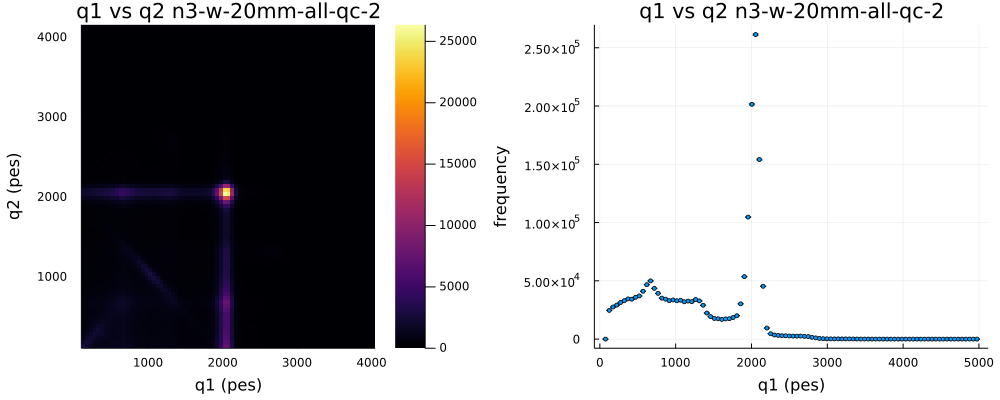

In [6]:
ANema.ANema.q1vsq2(ndf, tit="q1 vs q2 $config", filename=joinpath(plot_path, "q1q2"), save=true)

## Select photoelectric energy region

after q1q2 cut: ndfq has a length of 288007 fraction = 0.0576014


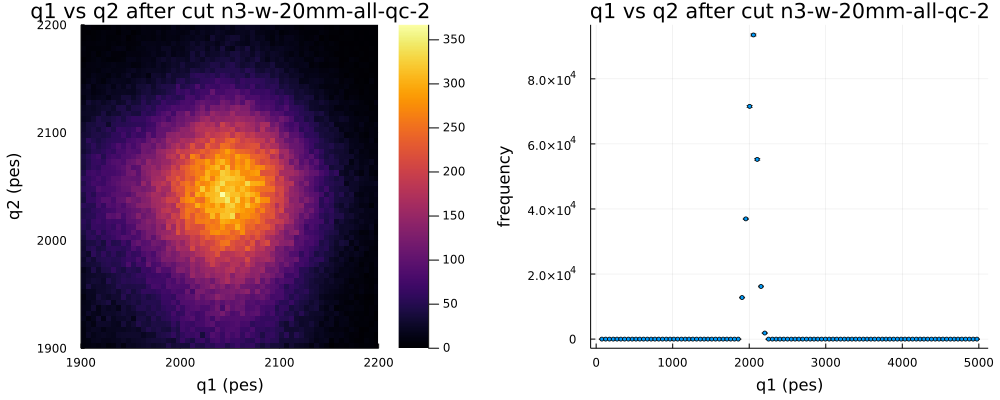

In [7]:
wmin = 1900.0
wmax = 2200.0
ndfq =ANema.selectinterval(ndf, "q1", "q2", wmin, wmax);
println("after q1q2 cut: ndfq has a length of ", nrow(ndfq), " fraction = ", nrow(ndfq)/norm)
ANema.q1vsq2(ndfq, tit="q1 vs q2 after cut $config", 
filename=joinpath(plot_path, "q1q2-qcut"), save=true)

## For the purposes of calibration, hemisphere 1 and hemisphere 2 give the same data. Combine relevant columns (zstd(1, 2), phistd(1, 2), r(1, 2), nsipm(1, 2)...

In [8]:
ring_df = DataFrame(r=vcat(ndfq.r1, ndfq.r2), nsipm=vcat(ndfq.nsipm1, ndfq.nsipm2), zstd=vcat(ndfq.zstd1, ndfq.zstd2), phistd=vcat(ndfq.phistd1, ndfq.phistd2))
println("Combined dataframe has ", nrow(ring_df), "rows.")

Combined dataframe has 576014rows.


In [9]:
## Add a column combining the two std measures in a radius using the sipm position.
sipm_r = 372.4
ring_df[!, "stdrad"] = sqrt.(ring_df.zstd.^2 + (sipm_r * tan.(ring_df.phistd)).^2)

576014-element Vector{Float64}:
  25.83016423718141
  16.82512177837747
  16.542780212353026
  18.919803166439557
  92.12903882272812
  19.09837727900651
  12.223444014850672
  11.28166880293298
  16.199069644473838
  14.072875352111142
  17.8479151626459
   7.023122207261303
  25.363999696861686
   ⋮
  24.010305751306717
  11.328578464639254
  12.758280240070594
  21.38377404684317
  15.139728777050657
  14.549229806134031
 477.74746606871076
  14.32873007376995
  13.076705563099424
  15.452308005303383
  14.108262956678116
   9.565300184486723

## Correlations between the size of the area of charge seen and the interaction radius

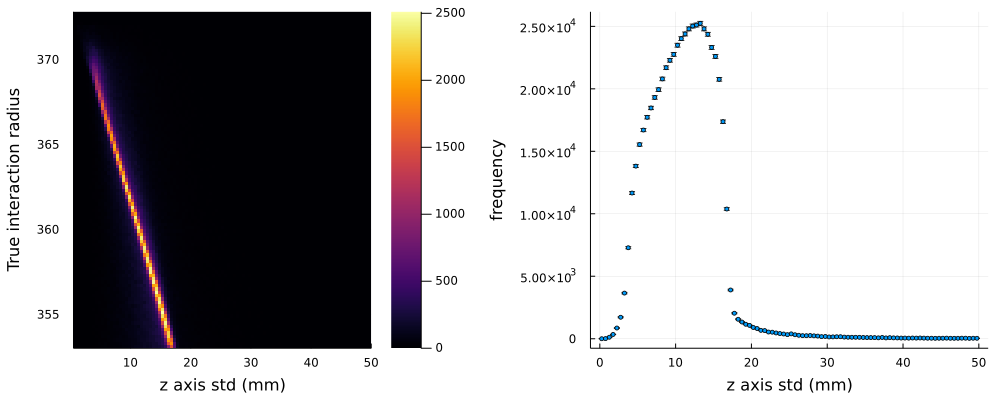

In [10]:
hzr, pzr = hist2d(ring_df.zstd, ring_df.r, 100, "z axis std (mm)", "True interaction radius", 0.0, 50.0, 350.0, 400.0)
hz , pz  = hist1d(ring_df.zstd, "z axis std (mm)", 100, 0.0, 50.0)
ANema.condplot(pzr, pz, " r = f(σz) $config", "", false)

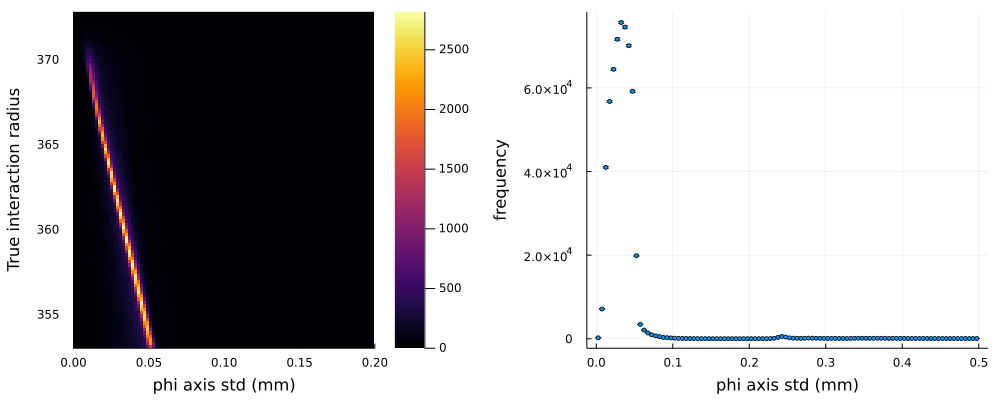

In [11]:
hpr, ppr = hist2d(ring_df.phistd, ring_df.r, 100, "phi axis std (mm)", "True interaction radius", 0.0, 0.2, 350.0, 400.0)
hp , pp  = hist1d(ring_df.phistd, "phi axis std (mm)", 100, 0.0, 0.5)
ANema.condplot(ppr, pp, " r = f(σϕ) $config", "", false)

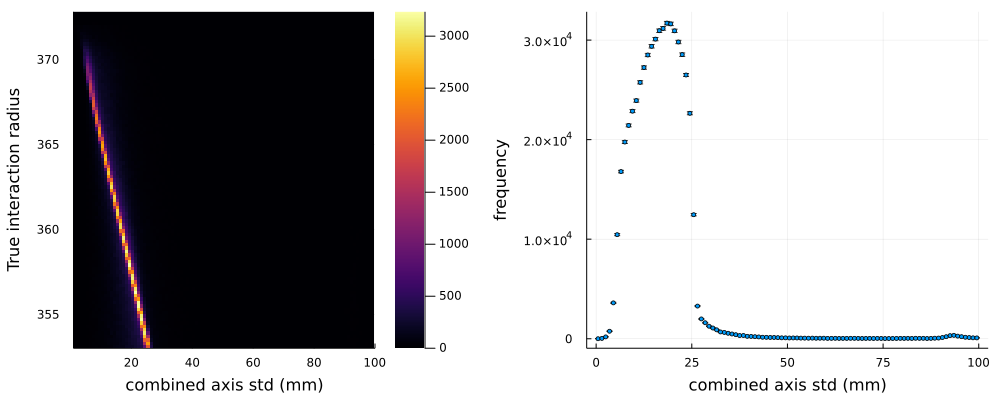

In [12]:
hcr, pcr = hist2d(ring_df.stdrad, ring_df.r, 100, "combined axis std (mm)", "True interaction radius", 0.0, 100.0, 350.0, 400.0)
hc , pc  = hist1d(ring_df.stdrad, "combined axis std (mm)", 100, 0.0, 100.0)
ANema.condplot(pcr, pc, " r = f(σcomb) $config", "", false)

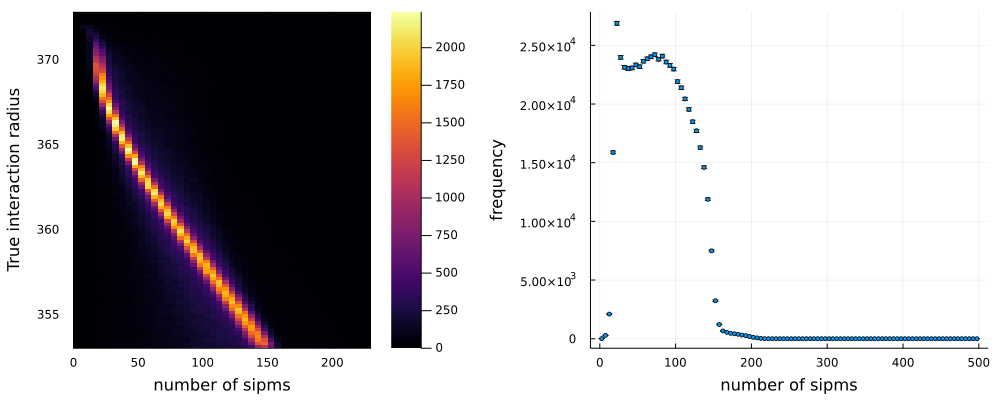

In [13]:
hnr, pnr = hist2d(Float64.(ring_df.nsipm), ring_df.r, 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hn , pn  = hist1d(Float64.(ring_df.nsipm), "number of sipms", 100, 0.0, 500.0)
ANema.condplot(pnr, pn, " r = f(nsipm) $config", "", false)

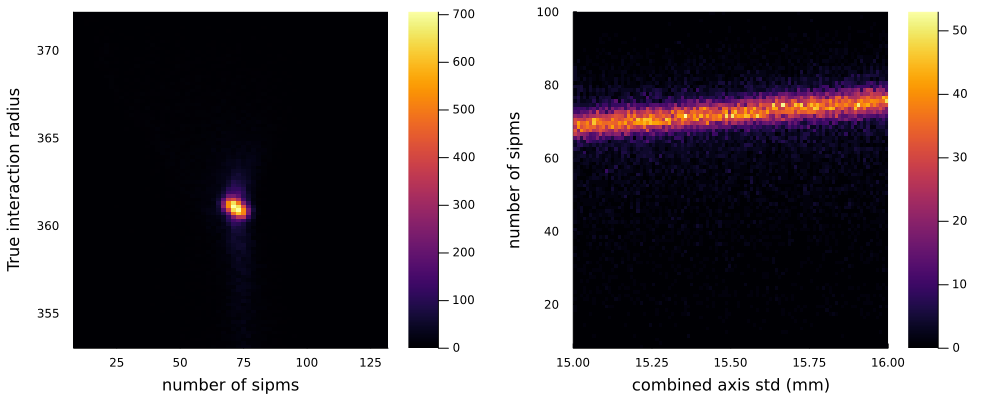

In [14]:
## Look at a specific 'bin' in the combined std
mask_std = (ring_df.stdrad .>= 15) .& (ring_df.stdrad .< 16)
hncr, pncr = hist2d(Float64.(ring_df[mask_std, "nsipm"]), ring_df[mask_std, "r"], 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 100.0)
ANema.condplot(pncr, pnc, " r = f(nsipm) $config", "", false)

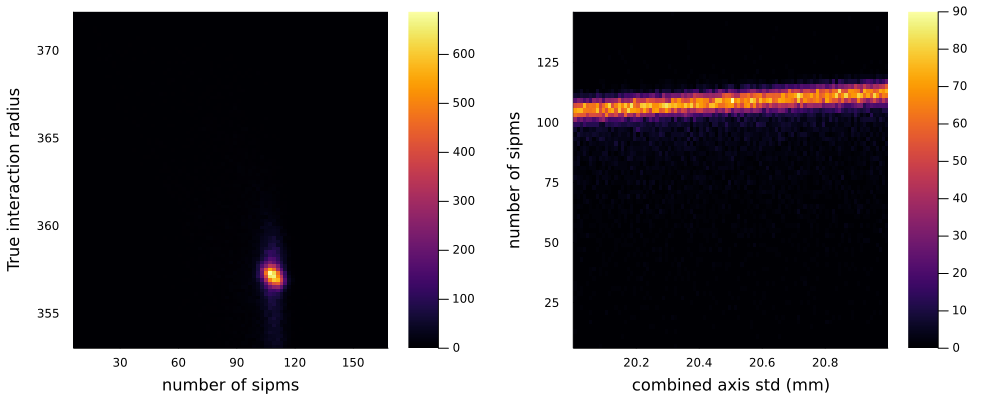

In [15]:
## Look at a specific 'bin' in the combined std
mask_std = (ring_df.stdrad .>= 20) .& (ring_df.stdrad .< 21)
hncr, pncr = hist2d(Float64.(ring_df[mask_std, "nsipm"]), ring_df[mask_std, "r"], 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 150.0)
ANema.condplot(pncr, pnc, " r = f(nsipm) $config", "", false)

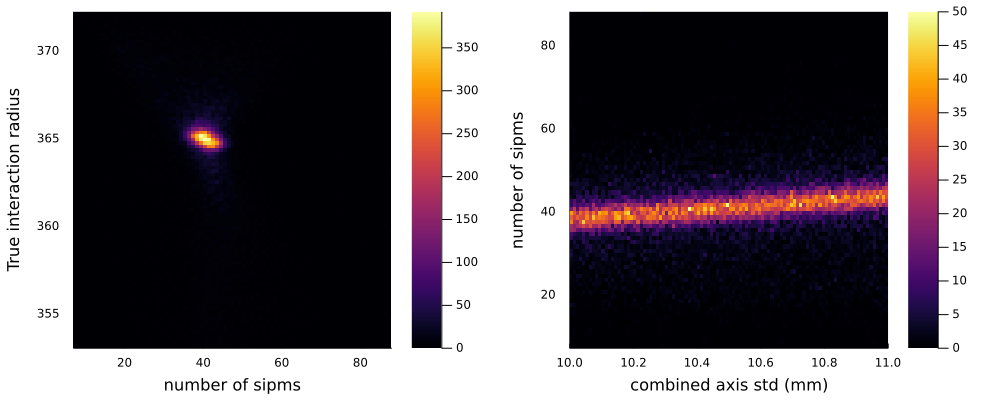

In [16]:
## Look at a specific 'bin' in the combined std
mask_std = (ring_df.stdrad .>= 10) .& (ring_df.stdrad .< 11)
hncr, pncr = hist2d(Float64.(ring_df[mask_std, "nsipm"]), ring_df[mask_std, "r"], 100, "number of sipms", "True interaction radius", 0.0, 500.0, 350.0, 400.0)
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 200.0)
ANema.condplot(pncr, pnc, " r = f(nsipm) $config", "", false)

# Make a selection in the zstd
and look at dependence in of r (DOI - sipm_r) with the parameters

In [22]:
mask_std = (ring_df.zstd .>= 2.0) .& (ring_df.zstd .< 16.0)
println("Masking keeps ", 100 * count(mask_std) / nrow(ring_df), "% of the interactions")

Masking keeps 90.63425541740305% of the interactions


Fit parameters: a = 373.00 b = -1.14 Fit errors: a =  0.06 b = 0.0065

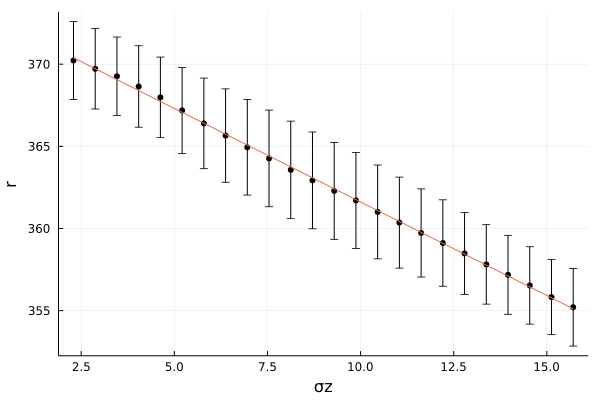

In [23]:
fzr, pzr = fit_profile(ring_df[mask_std, "zstd"], ring_df[mask_std, "r"], "σz", "r", "pol1")
fpars = fzr.fitpar
fstds = fzr.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr)

Fit parameters: a = 360.58 b = -0.22 Fit errors: a =   0.8 b =  0.31

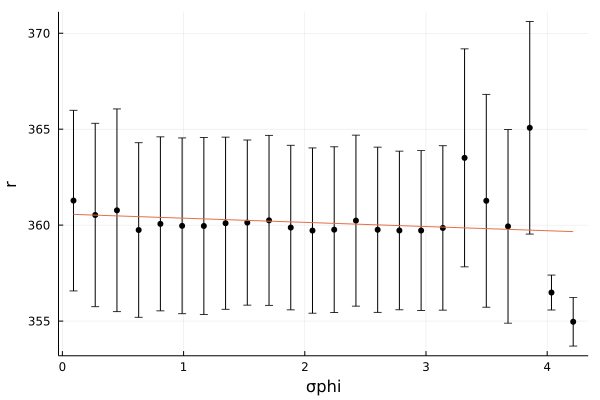

In [24]:
## phi
fpr, ppr = fit_profile(ring_df[mask_std, "phistd"], ring_df[mask_std, "r"], "σphi", "r", "pol1")
fpars = fpr.fitpar
fstds = fpr.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr)

Fit parameters: a = 360.61 b = -0.00 Fit errors: a =   0.8 b = 0.0069

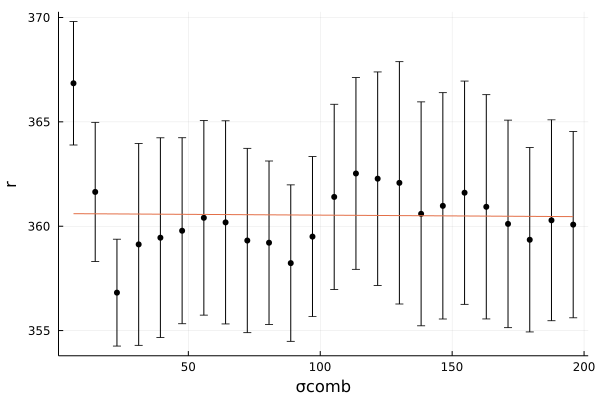

In [25]:
## comb. Needs an additional limit on itself to avoid errors
patch_mask = mask_std .& (ring_df.stdrad .< 200)
fcr, pcr = fit_profile(ring_df[patch_mask, "stdrad"], ring_df[patch_mask, "r"], "σcomb", "r", "pol1")
fpars = fcr.fitpar
fstds = fcr.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr)

# Masking with phi std?


In [30]:
mask_std = (ring_df.phistd .>= 0.005) .& (ring_df.phistd .< 0.05)
println("Masking keeps ", 100 * count(mask_std) / nrow(ring_df), "% of the interactions")

Masking keeps 90.34641519129744% of the interactions


Fit parameters: a = 372.34 b = -362.20 Fit errors: a =   0.1 b =   3.1

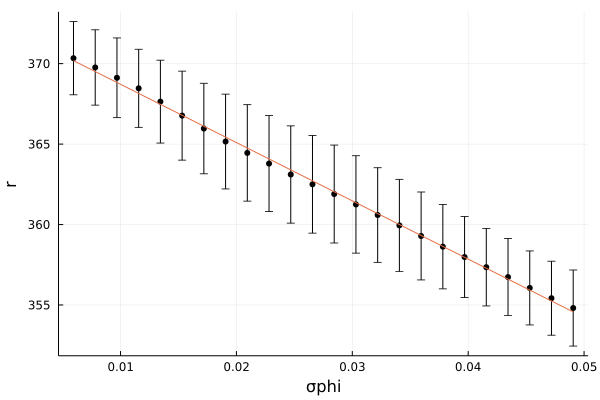

In [31]:
fpr2, ppr2 = fit_profile(ring_df[mask_std, "phistd"], ring_df[mask_std, "r"], "σphi", "r", "pol1")
fpars = fpr2.fitpar
fstds = fpr2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr2)

Fit parameters: a = 362.70 b = -0.07 Fit errors: a =     1 b = 0.028

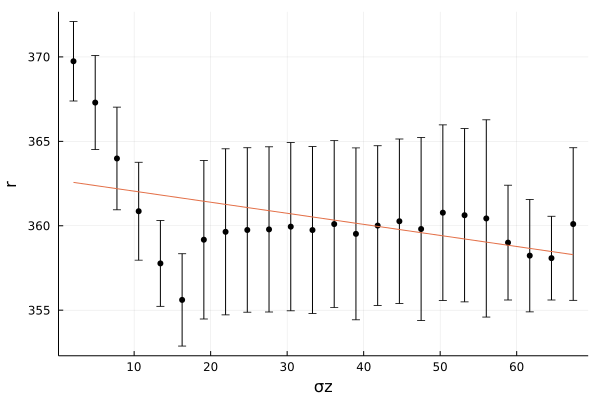

In [32]:
## zstd
## Needs a patch too.
patch_mask = mask_std .& (ring_df.zstd .< 70)
fzr2, pzr2 = fit_profile(ring_df[patch_mask, "zstd"], ring_df[patch_mask, "r"], "σz", "r", "pol1")
fpars = fzr2.fitpar
fstds = fzr2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

Fit parameters: a = 365.37 b = -0.17 Fit errors: a =     1 b = 0.047

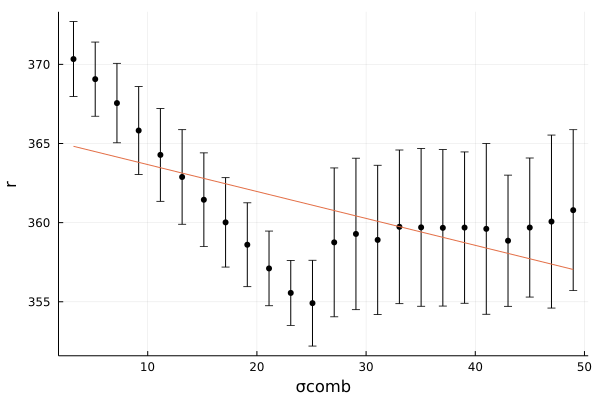

In [33]:
## comb. Needs an additional limit on itself to avoid errors
patch_mask = mask_std .& (ring_df.stdrad .< 50)
fcr2, pcr2 = fit_profile(ring_df[patch_mask, "stdrad"], ring_df[patch_mask, "r"], "σcomb", "r", "pol1")
fpars = fcr2.fitpar
fstds = fcr2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr2)

# Masking with combined std

In [38]:
mask_std = (ring_df.stdrad .>= 3.0) .& (ring_df.stdrad .< 25.0)
println("Masking keeps ", 100 * count(mask_std) / nrow(ring_df), "% of the interactions")

Masking keeps 91.0394539021621% of the interactions


Fit parameters: a = 372.85 b = -0.75 Fit errors: a =  0.08 b = 0.0051

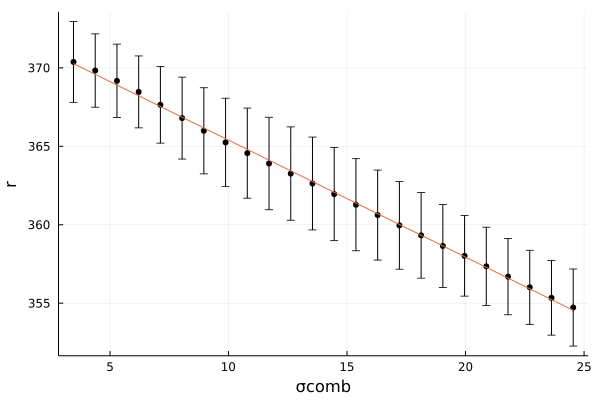

In [39]:
fcr3, pcr3 = fit_profile(ring_df[mask_std, "stdrad"], ring_df[mask_std, "r"], "σcomb", "r", "pol1")
fpars = fcr3.fitpar
fstds = fcr3.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr3)

Fit parameters: a = 367.15 b = -0.38 Fit errors: a =     2 b =  0.12

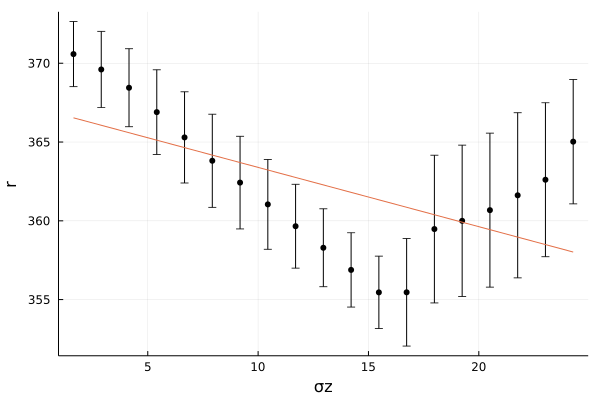

In [40]:
## zstd
fzr3, pzr3 = fit_profile(ring_df[mask_std, "zstd"], ring_df[mask_std, "r"], "σz", "r", "pol1", 20)
fpars = fzr3.fitpar
fstds = fzr3.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr3)

In [41]:
## phi
fpr3, ppr3 = fit_profile(ring_df[mask_std, "phistd"], ring_df[mask_std, "r"], "σphi", "r", "pol1")
fpars = fpr3.fitpar
fstds = fpr3.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr3)

LoadError: ArgumentError: New columns must have the same length as old columns

## Check the predicted R for all events using the fit from selection on each parameter (best always when select on the specific parameter)

In [42]:
ring_df[!, "rpredz"] = fzr.g.(ring_df.zstd)
ring_df[!, "rpredp"] = fpr2.g.(ring_df.phistd)
ring_df[!, "rpredc"] = fcr3.g.(ring_df.stdrad)

576014-element Vector{Float64}:
 353.5861082470559
 360.30219789590467
 360.5127722799446
 358.73995451367097
 304.13945795403185
 358.6067713827252
 363.73419508374076
 364.43658452623794
 360.76911654458235
 362.3548627022162
 359.53938394001034
 367.6126695742733
 353.93378043830035
   ⋮
 354.9433847724323
 364.40159862863027
 363.33530656628386
 356.90228973855767
 361.5591881368986
 361.99959072737744
  16.539711536393554
 362.1640425860865
 363.0978203994269
 361.32606207126184
 362.32847011985837
 365.71667682615663

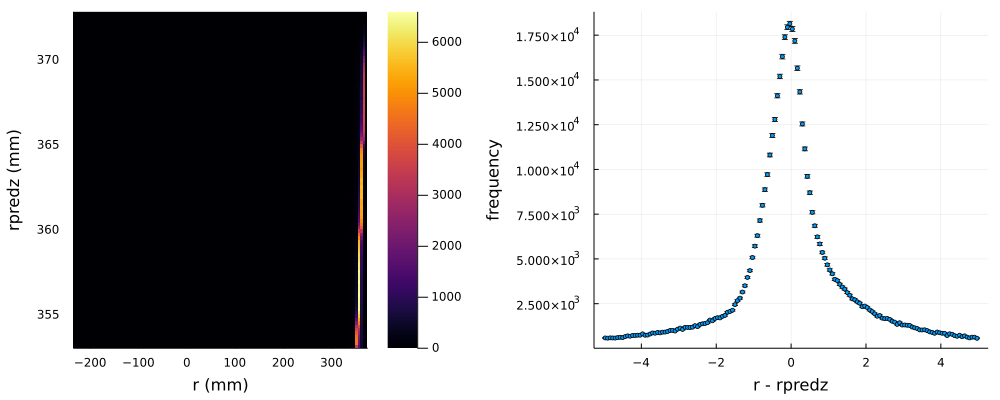

In [43]:
ANema.plotreso(ring_df.r, ring_df.rpredz, "r (mm)", "rpredz (mm)", -5., 5.0, tit="r - rpredz", filename=filename=joinpath(plot_path, "r-rpredz"), save=false)

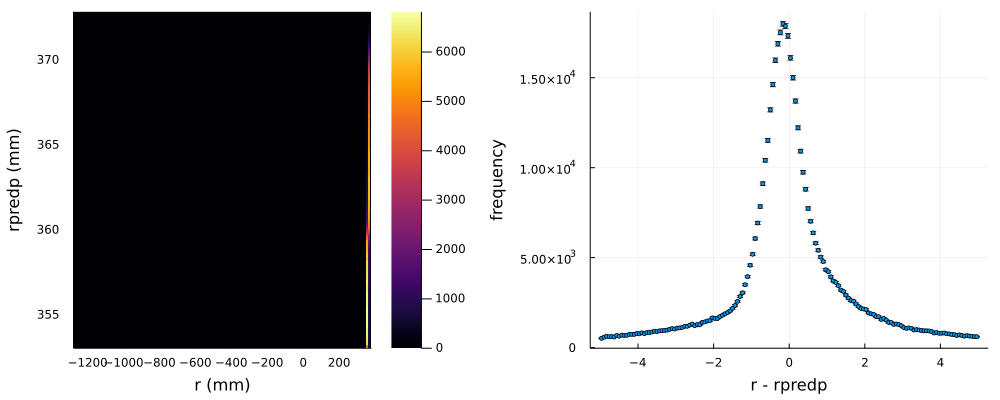

In [44]:
ANema.plotreso(ring_df.r, ring_df.rpredp, "r (mm)", "rpredp (mm)", -5., 5.0, tit="r - rpredp", filename=filename=joinpath(plot_path, "r-rpredp"), save=false)

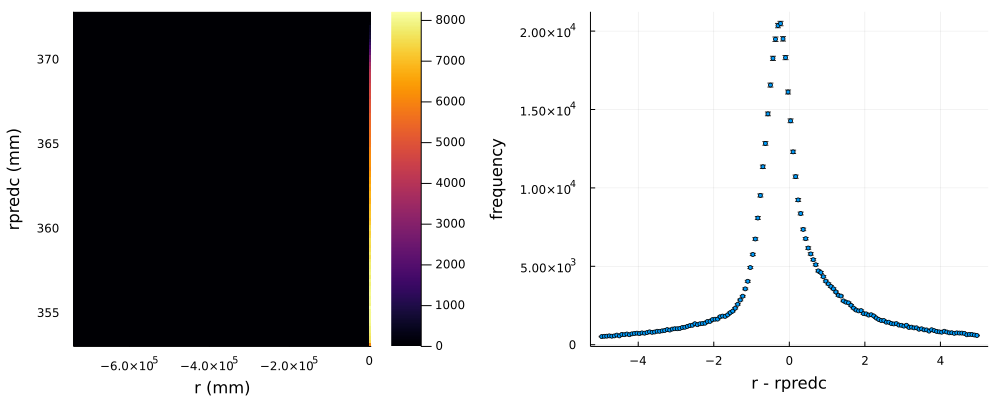

In [45]:
ANema.plotreso(ring_df.r, ring_df.rpredc, "r (mm)", "rpredc (mm)", -5., 5.0, tit="r - rpredc", filename=filename=joinpath(plot_path, "r-rpredc"), save=false)

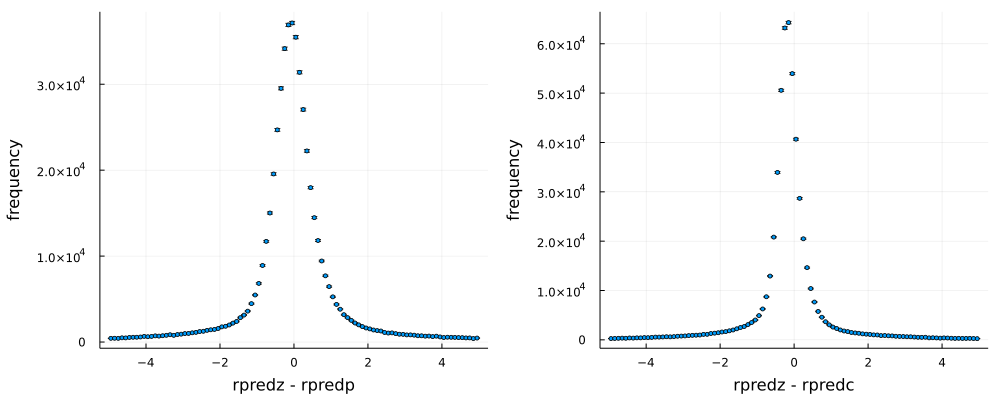

In [46]:
## Difference in predictions
diff1, pdiff1 = hist1d(ring_df.rpredz - ring_df.rpredp, "rpredz - rpredp", 100, -5.0, 5.0)
diff2, pdiff2 = hist1d(ring_df.rpredz - ring_df.rpredc, "rpredz - rpredc", 100, -5.0, 5.0)
ANema.condplot(pdiff1, pdiff2, "Diff predictions", "", false)

# Bias significantly less here with the 2 pe threshold on the SiPM charge

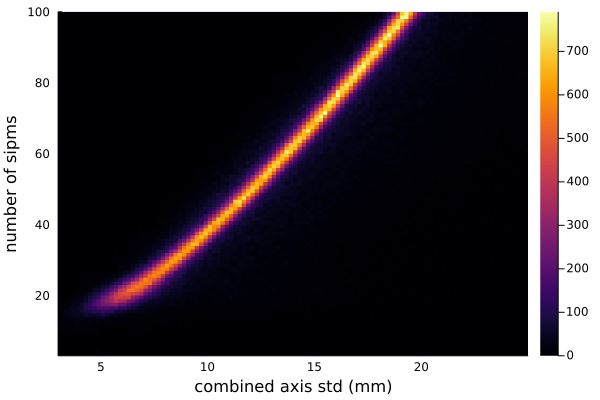

In [47]:
hnc , pnc  = hist2d(ring_df[mask_std, "stdrad"], Float64.(ring_df[mask_std, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 100.0)
plot(pnc)
#x1 = 10:0.72:28
#y1 = 8.0 .* x1 .- 60.0
#plot!(plot(x1, y1))

No obvious help from nsipm filtering here, leave the same

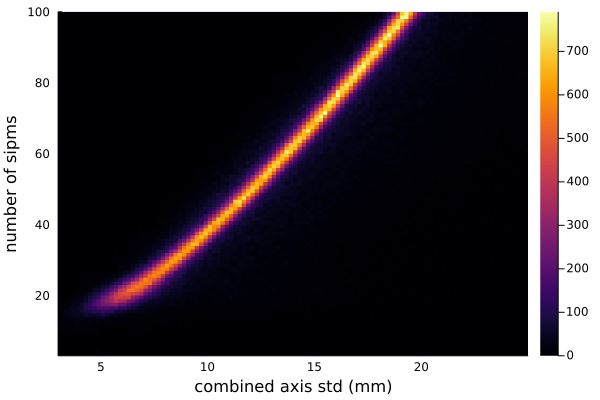

In [48]:
nsipm_mask = mask_std #.& (ring_df.nsipm .> 8.0 .* ring_df.stdrad .- 60.0)
#nsipm_mask = mask_std .& (ring_df.nsipm .> 40.0)
hnc2 , pnc2  = hist2d(ring_df[nsipm_mask, "stdrad"], Float64.(ring_df[nsipm_mask, "nsipm"]), 100, "combined axis std (mm)", "number of sipms", 0.0, 500.0, 0.0, 100.0)
plot(pnc2)

In [49]:
## Try
#mask_std2 = (ring_df.stdrad .>= 5.0) .& (ring_df.stdrad .< 30.0) .& (ring_df.nsipm .> 8.0 .* ring_df.stdrad .- 60.0)
println("Masking keeps ", 100 * count(mask_std) / nrow(ring_df), "% of the interactions")

Masking keeps 91.0394539021621% of the interactions


Fit parameters: a = 372.85 b = -0.75 Fit errors: a =  0.08 b = 0.0051

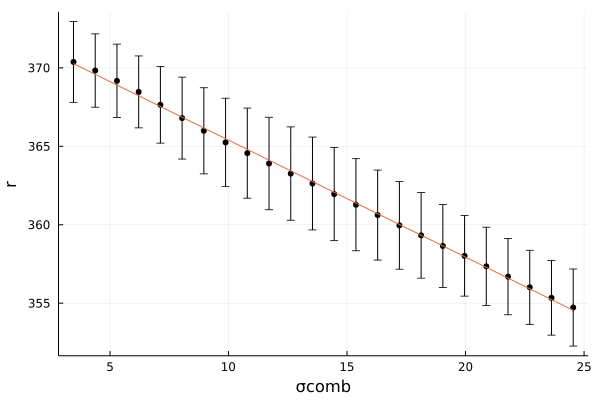

In [51]:
fcr4, pcr4 = fit_profile(ring_df[mask_std, "stdrad"], ring_df[mask_std, "r"], "σcomb", "r", "pol1")
fpars = fcr4.fitpar
fstds = fcr4.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f " fpars[1] fpars[2]
@printf "Fit errors: a = %5.1g b = %5.2g" fstds[1] fstds[2]
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr4)

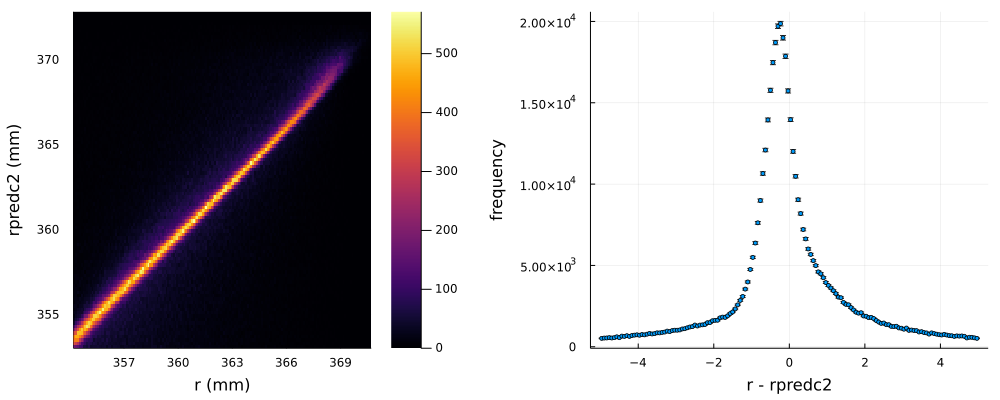

In [53]:
ring_df[!, "rpredc2"] = fcr4.g.(ring_df.stdrad)
ANema.plotreso(ring_df[mask_std, "r"], ring_df[mask_std, "rpredc2"], "r (mm)", "rpredc2 (mm)", -5., 5.0, tit="r - rpredc2", filename=filename=joinpath(plot_path, "r-rpredc2"), save=false)

 σ =     0.7 mm

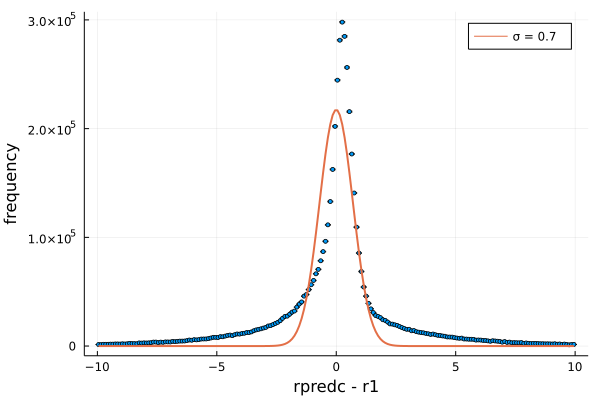

In [54]:
rpredc = ring_df[mask_std, "rpredc2"]
mask_r = ring_df[mask_std, "r"]
fg,p = fitg1(rpredc - mask_r, "rpredc - r1", 200, -10.0, 10.0, xgmin=-5.5, xgmax=5.5)
@printf " σ = %7.1f mm" fg.std[1] 
#ANema.pout(p,joinpath(pathp, "zstd-fitg1"))
plot(p)

In [68]:
## Add r predictions to original df (some functions currently expect the names 'r1x' and 'r2x'
ndfq[!, "stdrad1"] = sqrt.(ndfq.zstd1.^2 + (sipm_r * tan.(ndfq.phistd1)).^2)
ndfq[!, "r1x"] = fcr4.g.(ndfq.stdrad1)
ndfq[!, "stdrad2"] = sqrt.(ndfq.zstd2.^2 + (sipm_r * tan.(ndfq.phistd2)).^2)
ndfq[!, "r2x"] = fcr4.g.(ndfq.stdrad2)

288007-element Vector{Float64}:
 360.8018149277716
 366.68173443558226
 368.1664339232367
 360.39388535925866
 367.9881595823898
 359.1131498678652
 360.67715412879664
 365.70067930066307
 362.9412255330725
 364.65339291161746
 365.8138624438115
 367.4704164602016
 363.7849468082363
   ⋮
 354.9433847724323
 364.40159862863027
 363.33530656628386
 356.90228973855767
 361.5591881368986
 361.99959072737744
  16.539711536393554
 362.1640425860865
 363.0978203994269
 361.32606207126184
 362.32847011985837
 365.71667682615663

In [69]:
mask = (ndfq.stdrad1 .>= 3.0) .& (ndfq.stdrad1 .< 25.0) .& (ndfq.stdrad2 .>= 3.0) .& (ndfq.stdrad2 .< 25.0)
ndf_mask = ndfq[mask, :]
println("after masking cut: ndf_mask has a length of ", nrow(ndf_mask), " fraction = ", nrow(ndf_mask)/norm)

after masking cut: ndf_mask has a length of 238582 fraction = 0.0477164


## Best estimators

In [71]:
xp1,yp1,zp1 = ANema.radial_correction(ndf_mask.xr1, ndf_mask.yr1, ndf_mask.zr1, ndf_mask.r1x);
xp2,yp2,zp2 = ANema.radial_correction(ndf_mask.xr2, ndf_mask.yr2, ndf_mask.zr2, ndf_mask.r2x);

In [72]:
fg,px1 = fitg1(ndf_mask.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py1 = fitg1(ndf_mask.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz1 = fitg1(ndf_mask.zt1 - zp1, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]

 σx1 =  0.57 mm σy1 =  0.59 mm σz =  0.42 mm

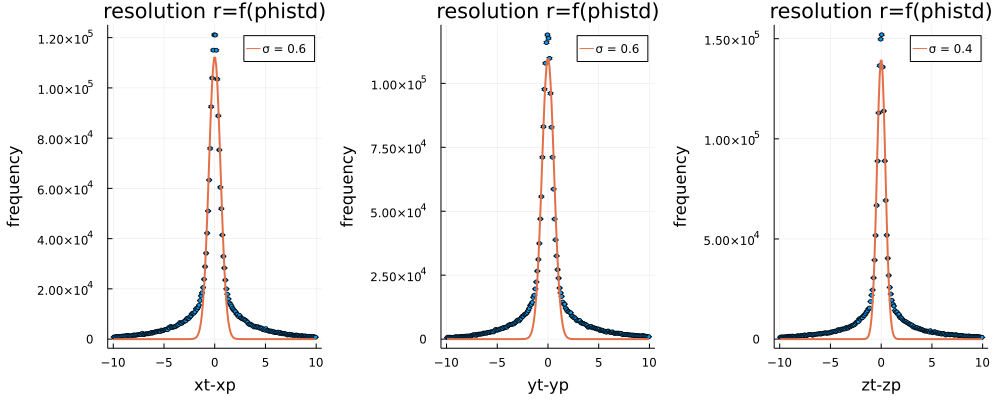

In [73]:
ANema.plot_and_save(px1,py1, pz1, "resolution r=f(phistd)", joinpath(plot_path, "phistd-res"))

x-x(rphi) σ1 =   2.919 σ2 =   0.459y-y(rphi) σ1 =   2.903 σ2 =   0.475z-z(rphi) σ1 =   2.577 σ2 =   0.343

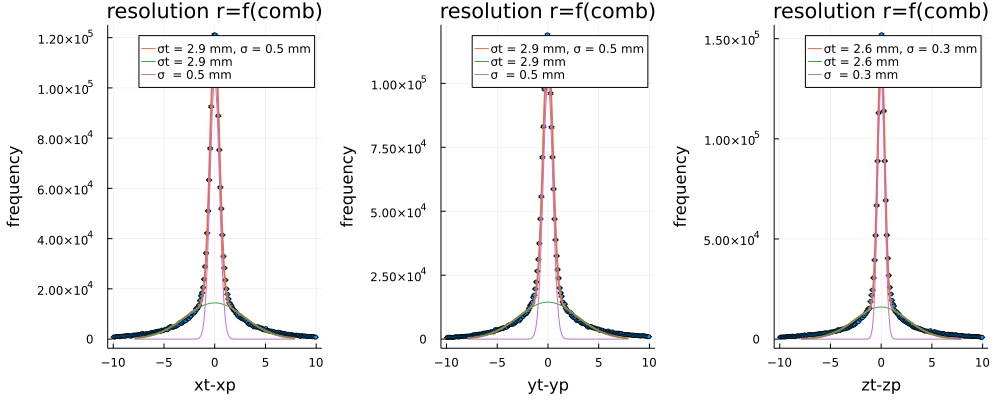

In [74]:
fg, px = fitg2(ndf_mask.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "x-x(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]

fg, py = fitg2(ndf_mask.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "y-y(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]

fg, pz = fitg2(ndf_mask.zt1 - zp1, "zt-zp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "z-z(rphi) σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.plot_and_save(px,py, pz, "resolution r=f(comb)", joinpath(plot_path, "phistd-res-2g"))

 σx1 =  0.51 mm σy1 =  0.54 mm σz =  0.38 mm

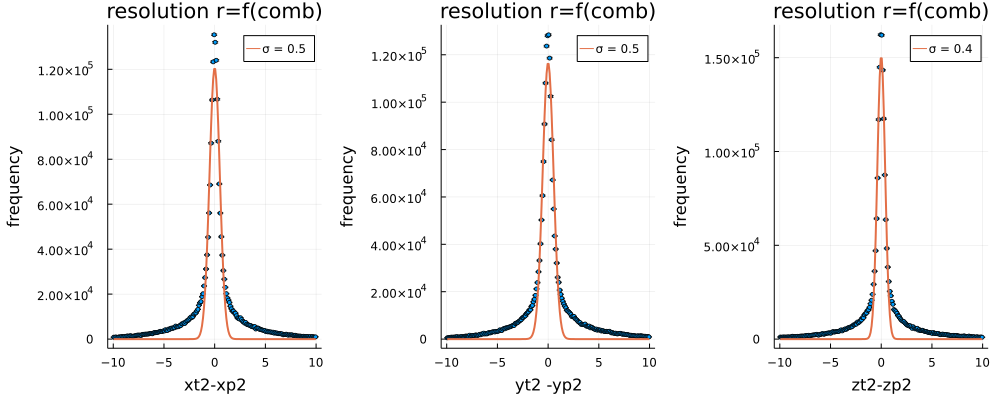

In [75]:
fg,px2 = fitg1(ndf_mask.xt2 - xp2, "xt2-xp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,py2 = fitg1(ndf_mask.yt2 - yp2, "yt2 -yp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pz2 = fitg1(ndf_mask.zt2 - zp2, "zt2-zp2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(px2,py2, pz2, "resolution r=f(comb)", joinpath(plot_path, "phistd-res")) 

# TOF

In [80]:
df_mask = ANema.setunits(ndf_mask);
# This will be formalised probably
# mm columns:
#len_cols = [:r1, :r2, :r1x, :r2x, :x1, :x2, :xb1, :xb2, :xr1, :xr2,
#            :xs, :xt1, :xt2, :y1, :y2, :yb1, :yb2, :yr1, :yr2, :ys, :yt1,   #          :yt2, :z1, :z2, :zb1, :zb2, :zr1, :zr2, :zs, :zt1, :zt2]
#transform!(ndf_mask, len_cols .=> (x -> x * mm), renamecols=false)
# ns cols:
#time_cols = [:t1, :t2, :ta1, :ta2, :tr1, :tr2]
#transform!(ndf_mask, time_cols .=> (x -> x * ns), renamecols=false)

First photon, position true: FWHM1 = 223.649 FWHM2 =  29.261

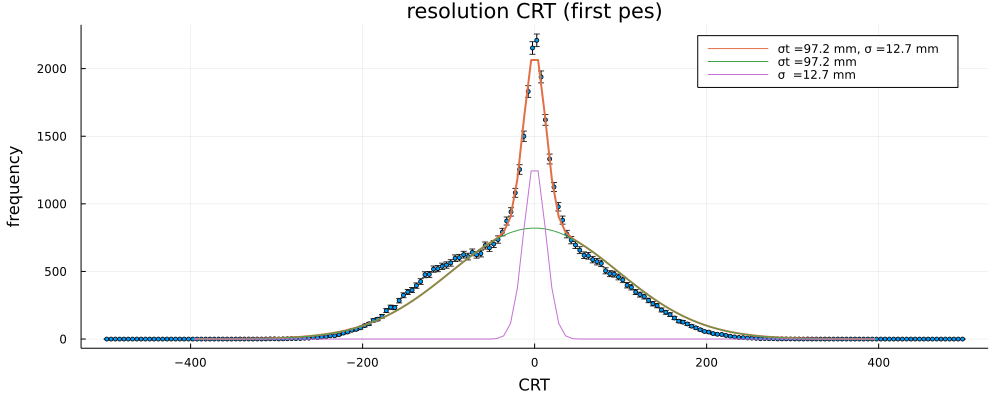

In [81]:
dt = ANema.crt(ndf_mask,  ANema.dtfirst, ANema.postrue)
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "First photon, position true: FWHM1 = %7.3f FWHM2 = %7.3f" 2.3*fg.std[1] 2.3*fg.std[2]
ANema.plot_and_save(p, "resolution CRT (first pes)", joinpath(plot_path, "CRT-first"))

fastest photoelectron, position reco: FWHM = 230.192

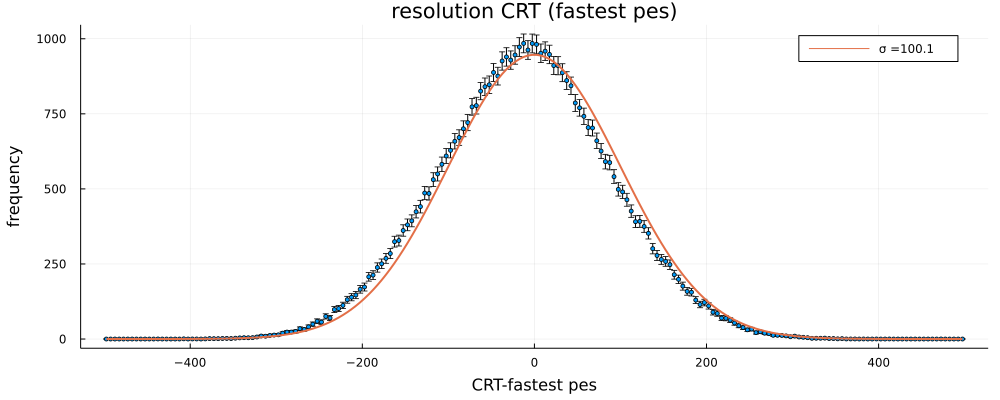

In [82]:
dt = ANema.crt(ndf_mask, ANema.dtminimum, ANema.postrue)
fg,p = fitg1(dt, "CRT-fastest pes", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(plot_path, "CRT-fastest"))

In [83]:
dt = ANema.crt(ndf_mask,  ANema.dtminimum, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes, reco pos)", joinpath(plot_path, "CRT-fastest-reco"))

LoadError: MethodError: no method matching radial_correction(::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Quantity{Float64, 𝐋⁻¹, Unitful.FreeUnits{(mm⁻¹,), 𝐋⁻¹, nothing}}})
[0mClosest candidates are:
[0m  radial_correction(::Vector{T}, ::Vector{T}, ::Vector{T}, [91m::Vector{T}[39m) where T at /Users/laingandrew/FiB/reco_code/ANema/src/dftolor.jl:72

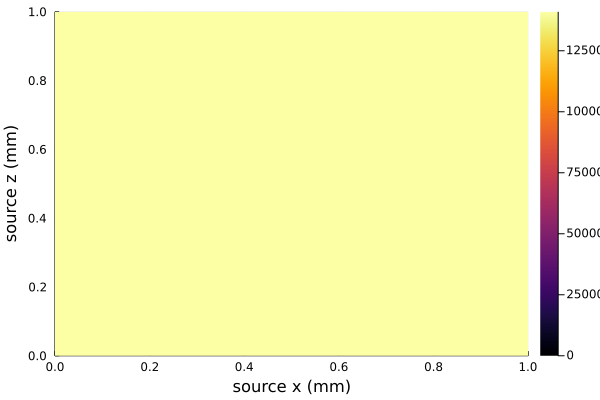

In [67]:
hpha, ppha = hist2d(ndf.xs, ndf.zs, 100, "source x (mm)", "source z (mm)", -200.0, 200.0, -200.0, 200.0)
plot(ppha)